# Extract annotations and data from DrugCentral

Purpose of this notebook is to extract and format drug data for subsequent model annotation.

## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"drugcentral"`
    * `"uniprot"`
* Currently uses the 2021 TSV file download.

### Citations
Avram S, Wilson TB, Curpan R, Halip L, Borota A, Bora A, Bologa CG, Holmes J, Knockel J, Yang JJ, Oprea TI. DrugCentral 2023 extends human clinical data and integrates veterinary drugs. Nucleic Acids Res. 2023 Jan 6;51(D1):D1276-D1287. doi: 10.1093/nar/gkac1085. PMID: 36484092; PMCID: PMC9825566.

## Setup
### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    GEM_NAME,
    build_string,
    compare_tables,
    explode_column,
    get_annotation_df,
    get_dirpath,
    read_cobra_model,
    visualize_comparison,
)
from rbc_gem_utils.database import DRUGCENTRAL_DB_TAG

## Set notebook options

In [2]:
compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True
download_database = True
db_tag = DRUGCENTRAL_DB_TAG


use_interim = False
database_dirpath = get_dirpath(
    "database", db_tag, use_temp="interim" if use_interim else None
)
annotation_dirpath = get_dirpath(
    "annotation", use_temp="interim" if use_interim else None
)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

mapping_key = "uniprot"

## Load DrugCentral data

In [3]:
df_drugcentral = pd.read_csv(
    database_dirpath / "drug.target.interaction.tsv",
    sep="\t",
    dtype=str,
)
# Filter out non-human entries
df_drugcentral = df_drugcentral[
    df_drugcentral["ORGANISM"].str.find("Homo sapiens") != -1
]
df_drugcentral

,DRUG_NAME,STRUCT_ID,TARGET_NAME,TARGET_CLASS,ACCESSION,GENE,SWISSPROT,ACT_VALUE,ACT_UNIT,ACT_TYPE,ACT_COMMENT,ACT_SOURCE,RELATION,MOA,MOA_SOURCE,ACT_SOURCE_URL,MOA_SOURCE_URL,ACTION_TYPE,TDL,ORGANISM
0,levobupivacaine,4,Potassium voltage-gated channel subfamily H me...,Ion channel,Q12809,KCNH2,KCNH2_HUMAN,4.89,NaN,IC50,Inhibition of wild-type human ERG channel expr...,CHEMBL,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
1,levobupivacaine,4,Sodium channel protein type 1 subunit alpha,Ion channel,P35498,SCN1A,SCN1A_HUMAN,5.79,NaN,IC50,NaN,WOMBAT-PK,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
2,levobupivacaine,4,Sodium channel protein type 4 subunit alpha,Ion channel,P35499,SCN4A,SCN4A_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,1,CHEMBL,NaN,https://www.ebi.ac.uk/chembl/compound/inspect/...,BLOCKER,Tclin,Homo sapiens
3,levobupivacaine,4,Prostaglandin E2 receptor EP1 subtype,GPCR,P34995,PTGER1,PE2R1_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
4,levobupivacaine,4,Cytochrome P450 2D6,Enzyme,P10635,CYP2D6,CP2D6_HUMAN,6.707,NaN,IC50,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DRUG MATRIX,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,infigratinib,5459,Fibroblast growth factor receptor 1,Kinase,P11362,FGFR1,FGFR1_HUMAN,8.99,NaN,NaN,Mechanism of Action,DRUG LABEL,=,1,DRUG LABEL,https://www.accessdata.fda.gov/drugsatfda_docs...,https://www.accessdata.fda.gov/drugsatfda_docs...,INHIBITOR,Tclin,Homo sapiens
19371,samidorphan,5460,Mu-type opioid receptor,GPCR,P35372,OPRM1,OPRM_HUMAN,10.28,NaN,Ki,Possible target for the mechanism of action of...,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,ANTAGONIST,Tclin,Homo sapiens
19372,samidorphan,5460,Kappa-type opioid receptor,GPCR,P41145,OPRK1,OPRK_HUMAN,9.64,NaN,Ki,NaN,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,PARTIAL AGONIST,Tclin,Homo sapiens
19373,samidorphan,5460,Delta-type opioid receptor,GPCR,P41143,OPRD1,OPRD_HUMAN,8.59,NaN,Ki,NaN,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,PARTIAL AGONIST,Tclin,Homo sapiens


## Load RBC-GEM model

In [4]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
model

Restricted license - for non-production use only - expires 2026-11-23


Name,RBC_GEM
Memory address,1d7055d2120
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Extract current annotations from model

In [5]:
annotation_type = "genes"
annotation_cols = ["uniprot", "drugbank", "drugcentral", "hgnc.symbol"]

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)

df_model_mappings

genes           820
uniprot         820
drugbank       2712
drugcentral     687
hgnc.symbol     821
dtype: int64


,genes,uniprot,drugbank,drugcentral,hgnc.symbol
0,A4GALT,Q9NPC4,<NA>,<NA>,A4GALT
1,AARS1,P49588,DB00160,<NA>,AARS1
2,AASDHPPT,Q9NRN7,<NA>,<NA>,AASDHPPT
3,ABCA1,O95477,DB11635,2269,ABCA1
4,ABCA1,O95477,DB01599,2269,ABCA1
...,...,...,...,...,...
118983,YES1,P07947,DB01254,4178,YES1
118984,ZDHHC2,Q9UIJ5,<NA>,<NA>,ZDHHC2
118985,ZDHHC20,Q5W0Z9,<NA>,<NA>,ZDHHC20
118986,ZDHHC3,Q9NYG2,<NA>,<NA>,ZDHHC3


### Map data to model

In [6]:
rename_mapping = {col: col.lower() for col in df_drugcentral.columns}
rename_mapping.update(
    {
        "ACCESSION": "uniprot",
        "GENE": "hgnc.symbol",
        "STRUCT_ID": "drugcentral",
        "drug_name": "name",
    }
)
df_model_drugcentral = pd.merge(
    df_model_mappings.loc[:, [annotation_type, mapping_key]],
    df_drugcentral.rename(rename_mapping, axis=1),
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)

df_model_drugcentral = df_model_drugcentral[df_model_drugcentral["drugcentral"].notna()]
# df_model_drugcentral = df_model_drugcentral.groupby(annotation_type, as_index=False).agg(lambda x:  build_string(list(x.dropna().unique())))
df_model_drugcentral = df_model_drugcentral.loc[
    :,
    [
        "genes",
        "uniprot",
        "hgnc.symbol",
        "drugcentral",
        "drug_name",
        "target_class",
        "action_type",
    ],
]
df_model_drugcentral = df_model_drugcentral.drop_duplicates().reset_index(drop=True)

if display_nunique:
    for col in df_model_drugcentral.columns:
        df = explode_column(df_model_drugcentral, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

df_model_drugcentral = df_model_drugcentral.reset_index(drop=True)


if overwrite:
    df_model_drugcentral.to_csv(
        database_dirpath / f"{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )

df_model_drugcentral

genes: 221
uniprot: 221
hgnc.symbol: 221
drugcentral: 687
drug_name: 687
target_class: 9
action_type: 13


,genes,uniprot,hgnc.symbol,drugcentral,drug_name,target_class,action_type
0,ABCA1,O95477,ABCA1,2269,probucol,Transporter,INHIBITOR
1,ABCB1,P08183,ABCB1,82,acrivastine,Transporter,NaN
2,ABCB1,P08183,ABCB1,114,alfentanil,Transporter,NaN
3,ABCB1,P08183,ABCB1,119,aliskiren,Transporter,NaN
4,ABCB1,P08183,ABCB1,176,amiodarone,Transporter,NaN
...,...,...,...,...,...,...,...
1522,YES1,P07947,YES1,4903,nintedanib,Kinase,NaN
1523,YES1,P07947,YES1,5231,midostaurin,Kinase,NaN
1524,YES1,P07947,YES1,5252,neratinib,Kinase,NaN
1525,YES1,P07947,YES1,5347,fedratinib,Kinase,NaN


genes: 221
uniprot: 221
hgnc.symbol: 221
drugcentral: 687


,genes,uniprot,hgnc.symbol,drugcentral
0,ABCA1,O95477,ABCA1,2269
1,ABCB1,P08183,ABCB1,82;114;119;176;191;219;242;249;254;271;276;419...
2,ABCC1,P33527,ABCC1,219;318;726;760;786;960;1112;1115;1414;1423;14...
3,ABCC4,O15439,ABCC4,269;1482;1708;1751;2632;2707
4,ABCC5,O15440,ABCC5,26;269;1708;1751;2441;2632;4392
...,...,...,...,...
216,TXNRD1,Q16881,TXNRD1,244;1763;4122;4349;4706
217,UMPS,P11172,UMPS,2002
218,VCP,P55072,VCP,719;1364;2817
219,YARS1,P54577,YARS,3064


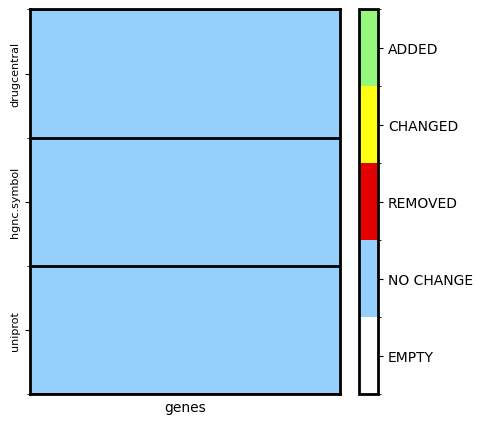

In [7]:
rename_mapping = {
    "ACCESSION": "uniprot",
    "GENE": "hgnc.symbol",
    "STRUCT_ID": "drugcentral",
}

df_annotations = pd.merge(
    df_model_mappings.loc[:, [annotation_type, mapping_key]],
    df_drugcentral.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1),
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)
df_annotations = df_annotations.dropna().drop_duplicates()
df_annotations = df_annotations.groupby(annotation_type).agg(
    lambda x: build_string(list(x.dropna().unique()))
)
df_annotations = df_annotations.reset_index(drop=False).dropna().drop_duplicates()
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations